In [8]:
unique_values_target = df['Target'].unique()
print("Unique values in 'Target' column:", unique_values_target)


Unique values in 'Target' column: ['0' 'O' 'I' 'R']


In [1]:
unique_values_target = df['Severity'].unique()
print("Unique values in 'Target' column:", unique_values_target)


NameError: name 'df' is not defined

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1/1 [==============================] - 0s 16ms/step
Fake Detection Metrics - Epoch 1:
Accuracy: 0.7539
Precision: 0.7517
Recall: 0.7539
F1 Score: 0.7527

Hate Detection Metrics - Epoch 1:
Accuracy: 0.9971
Precision: 1.0000
Recall: 0.9971
F1 Score: 0.9985

Target Classification Metrics - Epoch 1:
Accuracy: 0.6924
Precision: 0.6947
Recall: 0.6924
F1 Score: 0.6920

Severity Classification Metrics - Epoch 1:
Accuracy: 0.5420
Precision: 0.5502
Recall: 0.5420
F1 Score: 0.5455



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 18ms/step
Fake Detection Metrics - Epoch 2:
Accuracy: 0.7676
Precision: 0.7618
Recall: 0.7676
F1 Score: 0.7624

Hate Detection Metrics - Epoch 2:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Target Classification Metrics - Epoch 2:
Accuracy: 0.7139
Precision: 0.7170
Recall: 0.7139
F1 Score: 0.7140

Severity Classification Metrics - Epoch 2:
Accuracy: 0.5400
Precision: 0.5682
Recall: 0.5400
F1 Score: 0.5489

1/1 [==============================] - 0s 17ms/step
Fake Detection Metrics - Epoch 3:
Accuracy: 0.7842
Precision: 0.7837
Recall: 0.7842
F1 Score: 0.7840

Hate Detection Metrics - Epoch 3:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Target Classification Metrics - Epoch 3:
Accuracy: 0.7012
Precision: 0.7096
Recall: 0.7012
F1 Score: 0.7024

Severity Classification Metrics - Epoch 3:
Accuracy: 0.5410
Precision: 0.5663
Recall: 0.5410
F1 Score: 0.5488

1/1 [==============================] - 0s 18ms/s

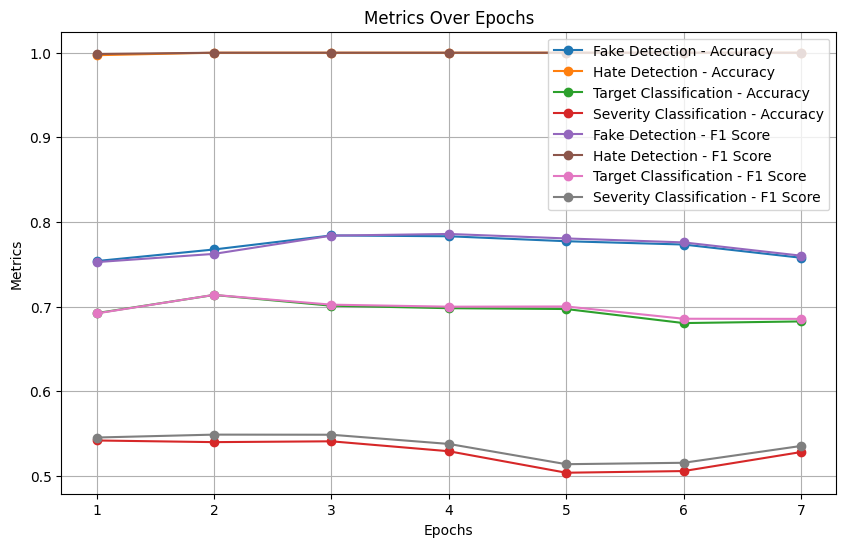

In [1]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset from your .xlsx file
input_file = "/kaggle/input/filtered-5k-hate1/full_data_8K_filtered.xlsx"
df = pd.read_excel(input_file)

# Load embeddings from "embeddings.pt"
all_embeddings = torch.load("/kaggle/input/bart-em/bart_embeddings.pt").detach().numpy()  # Load with PyTorch and convert to NumPy array

# Modify the dataset to include new labels
df['Target'] = df['Target'].map({'0': 0, 'I': 1, 'R': 2, 'O': 3})
df['Severity'] = df['Severity'].map({'0': 0, 'M': 1, 'L': 2, 'H': 3})

# Prepare the labels
labels_fake = tf.convert_to_tensor(df['Fake'].values)
labels_hate = tf.convert_to_tensor(df['Hate'].values)
labels_target = tf.convert_to_tensor(df['Target'].values)
labels_severity = tf.convert_to_tensor(df['Severity'].values)

# Convert TensorFlow tensors to NumPy arrays
labels_fake = labels_fake.numpy()
labels_hate = labels_hate.numpy()
labels_target = labels_target.numpy()
labels_severity = labels_severity.numpy()

# Split the data into train and test sets
(train_embeddings, test_embeddings, 
 train_labels_fake, test_labels_fake,
 train_labels_hate, test_labels_hate,
 train_labels_target, test_labels_target,
 train_labels_severity, test_labels_severity) = train_test_split(
    all_embeddings, labels_fake, labels_hate, labels_target, labels_severity, test_size=0.2, random_state=42
)

# Convert categorical labels to one-hot encoding
train_labels_target_one_hot = tf.keras.utils.to_categorical(train_labels_target, num_classes=4)
test_labels_target_one_hot = tf.keras.utils.to_categorical(test_labels_target, num_classes=4)

train_labels_severity_one_hot = tf.keras.utils.to_categorical(train_labels_severity, num_classes=4)
test_labels_severity_one_hot = tf.keras.utils.to_categorical(test_labels_severity, num_classes=4)

# Define a custom dataset for multi-task learning
class MultiTaskDataset(tf.keras.utils.Sequence):
    def __init__(self, embeddings, labels_fake, labels_hate, labels_target, labels_severity, batch_size):
        super().__init__()
        self.embeddings = embeddings
        self.labels_fake = labels_fake
        self.labels_hate = labels_hate
        self.labels_target = labels_target
        self.labels_severity = labels_severity
        self.batch_size = batch_size

    def __len__(self):
        return len(self.embeddings) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        return self.embeddings[start:end], (
            self.labels_fake[start:end],
            self.labels_hate[start:end],
            self.labels_target[start:end],
            self.labels_severity[start:end]
        )

# Create data loaders for training and testing
batch_size = 32
train_dataset = MultiTaskDataset(train_embeddings, train_labels_fake, train_labels_hate, train_labels_target_one_hot, train_labels_severity_one_hot, batch_size)
test_dataset = MultiTaskDataset(test_embeddings, test_labels_fake, test_labels_hate, test_labels_target_one_hot, test_labels_severity_one_hot, batch_size)

# Define the multi-task classification model in TensorFlow
def create_multi_task_model(input_dim):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    fake_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    fake_output = tf.keras.layers.Dense(1)(fake_layer)

    hate_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    hate_output = tf.keras.layers.Dense(1)(hate_layer)

    target_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    target_output = tf.keras.layers.Dense(4, activation='softmax')(target_layer)  # 4 labels for Target

    severity_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    severity_output = tf.keras.layers.Dense(4, activation='softmax')(severity_layer)  # 4 labels for Severity

    model = tf.keras.models.Model(inputs=input_layer, outputs=[fake_output, hate_output, target_output, severity_output])

    return model

model = create_multi_task_model(all_embeddings.shape[1])
# Compile the model with huber loss for fake and hate, and categorical crossentropy for target and severity
model.compile(loss=['huber_loss', 'huber_loss', 'categorical_crossentropy', 'categorical_crossentropy'],
              optimizer='adam', metrics=['accuracy'])

# Initialize and train the multi-task model
num_epochs = 7

# Lists to store metrics for each epoch
accuracy_fake_list = []
f1_fake_list = []
accuracy_hate_list = []
f1_hate_list = []
accuracy_target_list = []
f1_target_list = []
accuracy_severity_list = []
f1_severity_list = []

max_f1_fake = 0
max_f1_hate = 0
max_f1_target = 0
max_f1_severity = 0

best_epoch_fake = 0
best_epoch_hate = 0
best_epoch_target = 0
best_epoch_severity = 0

# Modify the calculate_metrics function
def calculate_metrics(y_true, y_pred, task_name, epoch):
    if 'target' in task_name.lower() or 'severity' in task_name.lower():
        y_pred = np.argmax(np.array(y_pred), axis=1)
    else:
        y_pred = (np.array(y_pred) >= 0.5).astype(int)
    
    y_true = y_true[:len(y_pred)]  # Ensure consistent lengths

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{task_name} Metrics - Epoch {epoch + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    return accuracy, f1  # Return the metrics

for epoch in range(num_epochs):
    for batch in train_dataset:
        embeddings, (labels_fake, labels_hate, labels_target, labels_severity) = batch
        model.train_on_batch(embeddings, [labels_fake, labels_hate, labels_target, labels_severity])

    # Evaluation on the test set
    fake_preds, hate_preds, target_preds, severity_preds = [], [], [], []
    for batch in test_dataset:
        embeddings, (labels_fake, labels_hate, labels_target, labels_severity) = batch
        fake_pred, hate_pred, target_pred, severity_pred = model.predict(embeddings)
        fake_preds.extend(fake_pred)
        hate_preds.extend(hate_pred)
        target_preds.extend(target_pred)
        severity_preds.extend(severity_pred)

    # Ensure consistent lengths of test labels and predictions
    min_length_fake = min(len(test_labels_fake), len(fake_preds))
    test_labels_fake_eval = test_labels_fake[:min_length_fake]
    fake_preds_binary = (np.array(fake_preds)[:min_length_fake] >= 0.5).astype(int)

    min_length_hate = min(len(test_labels_hate), len(hate_preds))
    test_labels_hate_eval = test_labels_hate[:min_length_hate]
    hate_preds_binary = (np.array(hate_preds)[:min_length_hate] >= 0.5).astype(int)

    min_length_target = min(len(test_labels_target), len(target_preds))
    test_labels_target_eval = test_labels_target[:min_length_target]

    min_length_severity = min(len(test_labels_severity), len(severity_preds))
    test_labels_severity_eval = test_labels_severity[:min_length_severity]

    # Calculate metrics for fake detection
    accuracy_fake, f1_fake = calculate_metrics(test_labels_fake_eval, fake_preds_binary, "Fake Detection", epoch)
    accuracy_fake_list.append(accuracy_fake)
    f1_fake_list.append(f1_fake)

    # Calculate metrics for hate detection
    accuracy_hate, f1_hate = calculate_metrics(test_labels_hate_eval, hate_preds_binary, "Hate Detection", epoch)
    accuracy_hate_list.append(accuracy_hate)
    f1_hate_list.append(f1_hate)

    # Calculate metrics for target classification
    accuracy_target, f1_target = calculate_metrics(test_labels_target_eval, target_preds, "Target Classification", epoch)
    accuracy_target_list.append(accuracy_target)
    f1_target_list.append(f1_target)

    # Calculate metrics for severity classification
    accuracy_severity, f1_severity = calculate_metrics(test_labels_severity_eval, severity_preds, "Severity Classification", epoch)
    accuracy_severity_list.append(accuracy_severity)
    f1_severity_list.append(f1_severity)

    # Update max_f1 values and best_epochs
    if f1_fake > max_f1_fake:
        max_f1_fake = f1_fake
        best_epoch_fake = epoch + 1

    if f1_hate > max_f1_hate:
        max_f1_hate = f1_hate
        best_epoch_hate = epoch + 1

    if f1_target > max_f1_target:
        max_f1_target = f1_target
        best_epoch_target = epoch + 1

    if f1_severity > max_f1_severity:
        max_f1_severity = f1_severity
        best_epoch_severity = epoch + 1

# Print the highest F1-scores and best epochs for each task
print(f"Highest F1-Score for Fake: {max_f1_fake:.4f} at Epoch {best_epoch_fake}")
print(f"Highest F1-Score for Hate: {max_f1_hate:.4f} at Epoch {best_epoch_hate}")
print(f"Highest F1-Score for Target: {max_f1_target:.4f} at Epoch {best_epoch_target}")
print(f"Highest F1-Score for Severity: {max_f1_severity:.4f} at Epoch {best_epoch_severity}")

# Display the classification reports at the end
print("Classification Report - Fake Detection:")
print(classification_report(test_labels_fake_eval, fake_preds_binary))

print("Classification Report - Hate Detection:")
print(classification_report(test_labels_hate_eval, hate_preds_binary))

# Print overall F1 score for Target Classification
print("Classification Report - Target Classification:")
target_classification_report = classification_report(test_labels_target_eval, np.argmax(np.array(target_preds), axis=1))
print(target_classification_report)
overall_f1_target = f1_score(test_labels_target_eval, np.argmax(np.array(target_preds), axis=1), average='weighted')
print(f"Overall F1 Score - Target Classification: {overall_f1_target:.4f}\n")

# Print overall F1 score for Severity Classification
print("Classification Report - Severity Classification:")
severity_classification_report = classification_report(test_labels_severity_eval, np.argmax(np.array(severity_preds), axis=1))
print(severity_classification_report)
overall_f1_severity = f1_score(test_labels_severity_eval, np.argmax(np.array(severity_preds), axis=1), average='weighted')
print(f"Overall F1 Score - Severity Classification: {overall_f1_severity:.4f}\n")



# Plotting the metrics
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

# Plotting Accuracy
plt.plot(epochs_range, accuracy_fake_list, label='Fake Detection - Accuracy', marker='o')
plt.plot(epochs_range, accuracy_hate_list, label='Hate Detection - Accuracy', marker='o')
plt.plot(epochs_range, accuracy_target_list, label='Target Classification - Accuracy', marker='o')
plt.plot(epochs_range, accuracy_severity_list, label='Severity Classification - Accuracy', marker='o')

# Plotting F1-score
plt.plot(epochs_range, f1_fake_list, label='Fake Detection - F1 Score', marker='o')
plt.plot(epochs_range, f1_hate_list, label='Hate Detection - F1 Score', marker='o')
plt.plot(epochs_range, f1_target_list, label='Target Classification - F1 Score', marker='o')
plt.plot(epochs_range, f1_severity_list, label='Severity Classification - F1 Score', marker='o')

plt.title('Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()
